In [ ]:
# '/btbwar/XC139608.mp3'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import io
import librosa
import warnings
warnings.filterwarnings('ignore') # get rid of librosa warnings

In [3]:
import pywt
import math

In [ ]:
# CWT에 PyWavelets를 사용할 수 있지만 여기서는 Alexander Neergaard의 CWT의 수정된 버전을 사용하겠습니다.
# 특히 가장 긴 웨이블릿(가장 낮은 주파수)을 차단할 수 있도록 매개변수가 추가됩니다.

In [4]:
# Continous Wavelet Transform with Morlet wavelet
# Original code by Alexander Neergaard, https://github.com/neergaard/CWT
#
# Parameters:
#   data: input data
#   nv: # of voices (scales) per octave
#   sr: sampling frequency (Hz)
#   low_freq: lowest frequency (Hz) of interest (limts longest scale)


In [5]:
def cwt2(data, nv=10, sr=1., low_freq=0.):
    data -= np.mean(data)
    n_orig = data.size
    ds = 1 / nv
    dt = 1 / sr

    # Pad data symmetrically
    padvalue = n_orig // 2
    x = np.concatenate((np.flipud(data[0:padvalue]), data, np.flipud(data[-padvalue:])))
    n = x.size

    # Define scales
    _, _, wavscales = getDefaultScales(n_orig, ds, sr, low_freq)
    num_scales = wavscales.size

    # Frequency vector sampling the Fourier transform of the wavelet
    omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
    omega *= (2 * np.pi) / n
    omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))

    # Compute FFT of the (padded) time series
    f = np.fft.fft(x)

    # Loop through all the scales and compute wavelet Fourier transform
    psift, freq = waveft(omega, wavscales)

    # Inverse transform to obtain the wavelet coefficients.
    cwtcfs = np.fft.ifft(np.kron(np.ones([num_scales, 1]), f) * psift)
    cfs = cwtcfs[:, padvalue:padvalue + n_orig]
    freq = freq * sr

    return cfs, freq

In [6]:
def getDefaultScales(n, ds, sr, low_freq):
    nv = 1 / ds
    # Smallest useful scale (default 2 for Morlet)
    s0 = 2

    # Determine longest useful scale for wavelet
    max_scale = n // (np.sqrt(2) * s0)
    if max_scale <= 1:
        max_scale = n // 2
    max_scale = np.floor(nv * np.log2(max_scale))
    a0 = 2 ** ds
    scales = s0 * a0 ** np.arange(0, max_scale + 1)

    # filter out scales below low_freq
    fourier_factor = 6 / (2 * np.pi)
    frequencies = sr * fourier_factor / scales
    frequencies = frequencies[frequencies >= low_freq]
    scales = scales[0:len(frequencies)]

    return s0, ds, scales

In [7]:
def waveft(omega, scales):
    num_freq = omega.size
    num_scales = scales.size
    wft = np.zeros([num_scales, num_freq])

    gC = 6
    mul = 2
    for jj, scale in enumerate(scales):
        expnt = -(scale * omega - gC) ** 2 / 2 * (omega > 0)
        wft[jj, ] = mul * np.exp(expnt) * (omega > 0)

    fourier_factor = gC / (2 * np.pi)
    frequencies = fourier_factor / scales

    return wft, frequencies

In [8]:
# FFT vs Spectrogram vs Scaleogram

In [ ]:
import scipy.fftpack
from scipy import signal
from scipy.signal import chirp

DB_RANGE = 100 # dynamic range to show in dB
# SR = 2250
SR = 273000
CMAP = 'magma'

def show_sigx3(d):
    fig, axes = plt.subplots(1, 3, figsize=(16,5))

    # FFT
    N, T = SR, 1./SR
    x = np.linspace(0.0, int(N*T), N)
    yf = scipy.fftpack.fft(d*np.hamming(len(d))) # FFT
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    axes[0].plot(xf,  20*np.log10(2.0/N *np.abs(yf[:N//2])))
    axes[0].set_ylim(-80,0)
    axes[0].set_title('FFT')

    # Spectrogram
    # f, t, Sxx = signal.spectrogram(d, SR) # spectrogram
    f, t, Sxx = signal.spectrogram(d, fs = 1, nfft = 300000)
    axes[1].pcolormesh(t, f, 20*np.log10(Sxx), shading='auto') #, cmap=CMAP, vmax=-60, vmin=-60-DB_RANGE)
    axes[1].set_title('Spectrogram')

    # CWT_Alexander Neergaard
    # cs, f = calc_cwt(d)
    cs, f = cwt2(d, nv=12, sr=SR, low_freq=40) # continuous wavelet transform
    axes[2].imshow(20*np.log10(np.abs(cs)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-DB_RANGE)
    axes[2].set_title('Scaleogram')
    plt.show()

In [ ]:
import scipy.fftpack
from scipy import signal
from scipy.signal import chirp

In [ ]:
# SR = 4550
SR = 273000
d = np.random.randn(SR)

In [ ]:
f_spe, t_spe, Sxx_spe = signal.spectrogram(d, fs = 1, nfft = 300000) # spectrogram

In [ ]:
np.shape(Sxx_spe)

(150001, 1218)

In [ ]:
Sxx_spe

array([[0.03993689],
       [0.20861358],
       [0.05649889],
       [0.07010044],
       [0.38005602],
       [0.46087807],
       [0.63745105],
       [0.13239143],
       [0.33210341],
       [0.39200664],
       [1.07264883],
       [0.03777637],
       [0.70865855],
       [0.66281031],
       [0.52596974],
       [0.52716225],
       [0.27613636],
       [0.3311456 ],
       [0.28708465],
       [0.0217857 ],
       [0.53729655],
       [0.08934339],
       [0.00844437],
       [0.51676968],
       [0.37731214],
       [0.06205961],
       [0.04589053],
       [0.47550963],
       [0.66582752],
       [0.68391126],
       [0.65375157],
       [0.46310189],
       [0.05847901]])

In [ ]:
d = np.random.randn(SR)
show_sigx3(d)

In [ ]:
from IPython.display import Audio
from sklearn.preprocessing import minmax_scale

TRAIN_DIR = '/content/drive/MyDrive/Birdsong'
# SR = 22050 # sample rate in Hz
SR = 4550

def rd_file(fname, offset=0, duration=60):
    data, _ = librosa.load(fname, sr=SR, mono=True, offset=offset, duration=duration)
    data = minmax_scale(data-data.mean(), feature_range=(-1,1))
    return data

# load a file with Black-throated Blue Warbler
d1 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Alaudaarvensis105516.mp3')
#d1 = rd_file(TRAIN_DIR+'/btbwar/XC139608.mp3')
#d1 = d1[:500000] # cuting
Audio(d1, rate=SR)

type(d1)
d1.shape

(273000,)

In [ ]:
d1_sli = d1[2000:6550]
d1_sli.shape

(4550,)

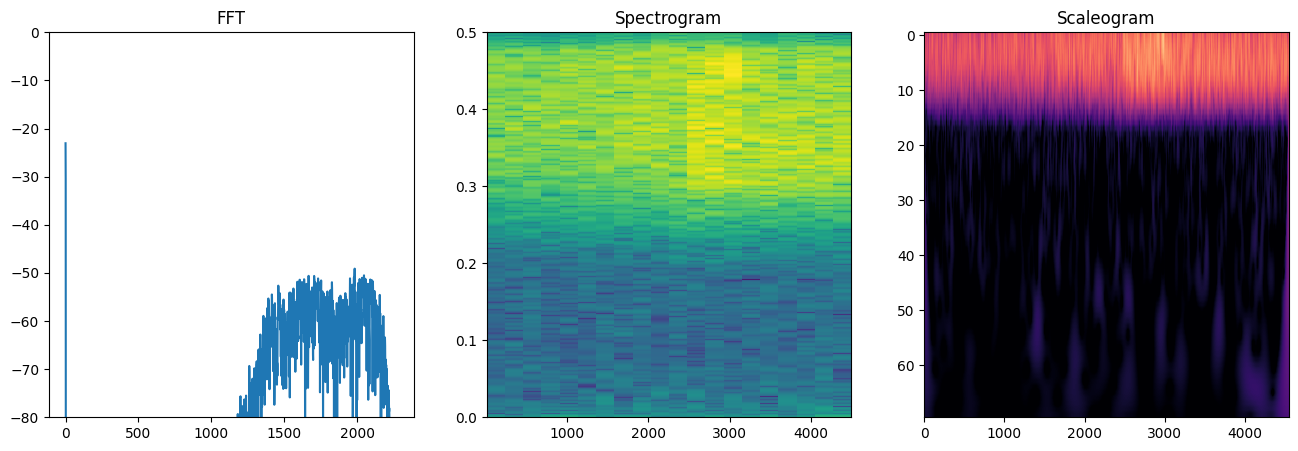

In [ ]:
show_sigx3(d1_sli)

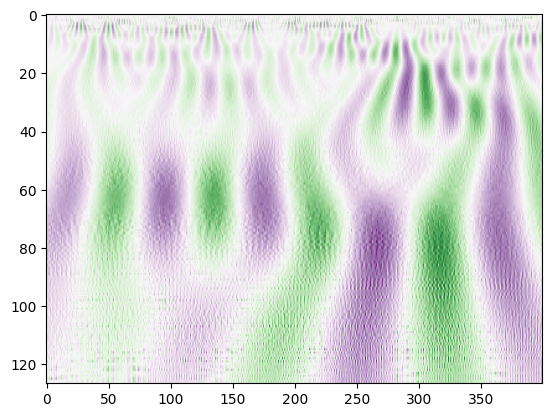

In [ ]:
# CWT_PyWavelets
widths = np.arange(1,128)
cs1, f1 = pywt.cwt(d, widths, "morl", sampling_period=1/SR)
plt.imshow(cs1,cmap='PRGn', aspect='auto',vmax=abs(cs1).max(), vmin=-abs(cs1).max())
#plt.imshow(20*np.log10(np.abs(cs1)),cmap='PRGn', aspect='auto',vmax=abs(cs1).max(), vmin=-abs(cs1).max())
plt.show()

In [ ]:
# bird song

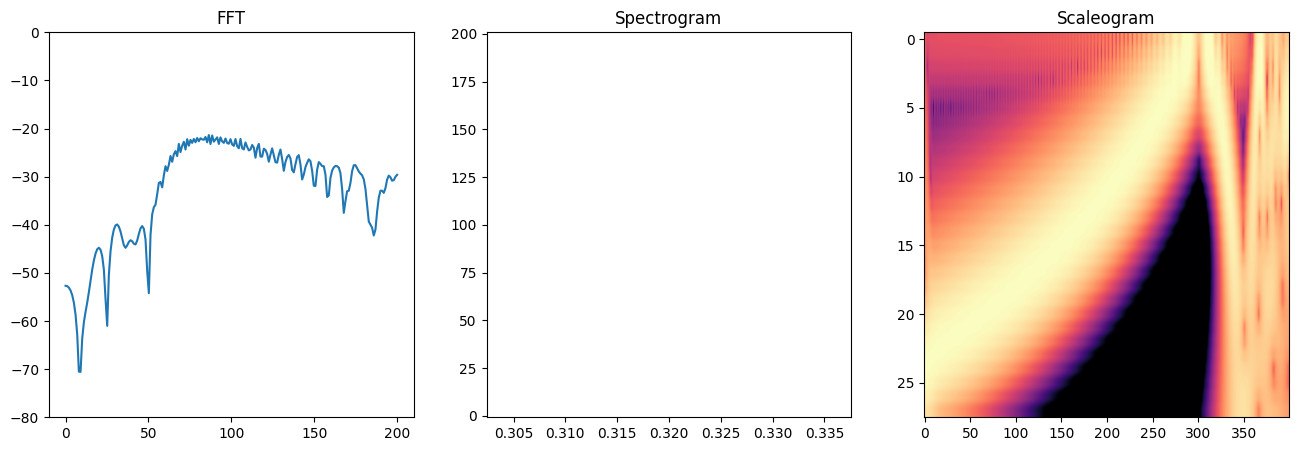

In [ ]:
t = np.linspace(0, 1, SR)
d = chirp(t, f0=50, f1=10e3, t1=1., method='hyperbolic')
show_sigx3(d)

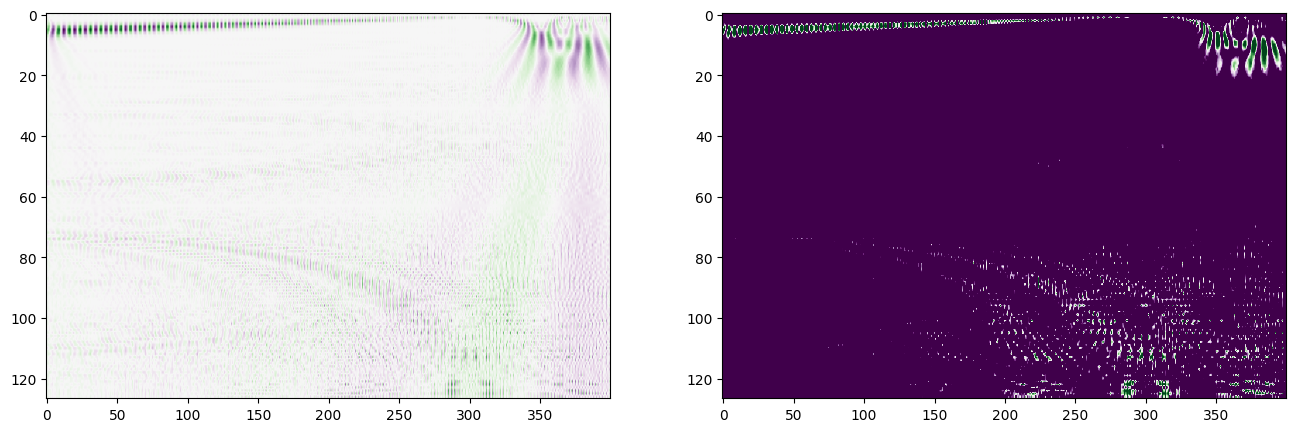

In [ ]:
# CWT_PyWavelets
widths = np.arange(1,128)
cs1, f1 = pywt.cwt(d, widths, "morl", sampling_period=1/SR)

fig, axes = plt.subplots(1, 2, figsize=(16,5))
axes[0].imshow(cs1,cmap='PRGn', aspect='auto',vmax=abs(cs1).max(), vmin=-abs(cs1).max())
axes[1].imshow(20*np.log10(np.abs(cs1)),cmap='PRGn', aspect='auto',vmax=abs(cs1).max(), vmin=-abs(cs1).max())
plt.show()

In [ ]:
#'/scratch/e1372a04/workspace/test2_birdsong/HereData/Alaudaarvensis/Germany/Alaudaarvensis105516.mp3'
#'/scratch/e1372a04/workspace/test2_birdsong/HereData/Phoenicurusochruros/Germany/Phoenicurusochruros184490.mp3'

In [ ]:
# /content/drive/MyDrive/Birdsong/Birds/Alaudaarvensis105516.mp3 /content/drive/MyDrive/Birdsong/Birds/Phoenicurusochruros184490.mp3

In [ ]:
from IPython.display import Audio
from sklearn.preprocessing import minmax_scale

TRAIN_DIR = '/content/drive/MyDrive/Birdsong'
#SR = 22050 # sample rate in Hz
SR = 4550

def rd_file(fname, offset=0, duration=60):
    data, _ = librosa.load(fname, sr=SR, mono=True, offset=offset, duration=duration)
    data = minmax_scale(data-data.mean(), feature_range=(-1,1))
    return data

In [ ]:
# load a file with Black-throated Blue Warbler
d1 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Alaudaarvensis105516.mp3')
#d1 = rd_file(TRAIN_DIR+'/btbwar/XC139608.mp3')
#d1 = d1[:500000] # cuting
Audio(d1, rate=SR)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import io
import librosa
import warnings
warnings.filterwarnings('ignore') # get rid of librosa warnings
from IPython.display import Audio
from sklearn.preprocessing import minmax_scale
import math

def rd_file(fname, offset=0, duration=60):
    data, _ = librosa.load(fname, sr=SR, mono=True, offset=offset, duration=duration)
    data = minmax_scale(data-data.mean(), feature_range=(-1,1))
    return data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def cwt2(data, nv=10, sr=1., low_freq=0.):
    data -= np.mean(data)
    n_orig = data.size
    ds = 1 / nv
    dt = 1 / sr

    # Pad data symmetrically
    padvalue = n_orig // 2
    x = np.concatenate((np.flipud(data[0:padvalue]), data, np.flipud(data[-padvalue:])))
    n = x.size

    # Define scales
    _, _, wavscales = getDefaultScales(n_orig, ds, sr, low_freq)
    num_scales = wavscales.size

    # Frequency vector sampling the Fourier transform of the wavelet
    omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
    omega *= (2 * np.pi) / n
    omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))

    # Compute FFT of the (padded) time series
    f = np.fft.fft(x)

    # Loop through all the scales and compute wavelet Fourier transform
    psift, freq = waveft(omega, wavscales)

    # Inverse transform to obtain the wavelet coefficients.
    cwtcfs = np.fft.ifft(np.kron(np.ones([num_scales, 1]), f) * psift)
    cfs = cwtcfs[:, padvalue:padvalue + n_orig]
    freq = freq * sr

    return cfs, freq

def getDefaultScales(n, ds, sr, low_freq):
    nv = 1 / ds
    # Smallest useful scale (default 2 for Morlet)
    s0 = 2

    # Determine longest useful scale for wavelet
    max_scale = n // (np.sqrt(2) * s0)
    if max_scale <= 1:
        max_scale = n // 2
    max_scale = np.floor(nv * np.log2(max_scale))
    a0 = 2 ** ds
    scales = s0 * a0 ** np.arange(0, max_scale + 1)

    # filter out scales below low_freq
    fourier_factor = 6 / (2 * np.pi)
    frequencies = sr * fourier_factor / scales
    frequencies = frequencies[frequencies >= low_freq]
    scales = scales[0:len(frequencies)]

    return s0, ds, scales

def waveft(omega, scales):
    num_freq = omega.size
    num_scales = scales.size
    wft = np.zeros([num_scales, num_freq])

    gC = 6
    mul = 2
    for jj, scale in enumerate(scales):
        expnt = -(scale * omega - gC) ** 2 / 2 * (omega > 0)
        wft[jj, ] = mul * np.exp(expnt) * (omega > 0)

    fourier_factor = gC / (2 * np.pi)
    frequencies = fourier_factor / scales

    return wft, frequencies

In [ ]:
SR = 22050
CMAP = 'magma'

d1_1 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Alaudaarvensis105516.mp3')
d1_2 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Chlorischloris102473.mp3')
d1_3 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Delichonurbicum256027.mp3')
d1_4 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Phoenicurusochruros172582.mp3')
d1_5 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Streptopeliadecaocto246323.mp3')

sho = d1_5

Audio(sho, rate=SR)
type(sho)
print(sho.shape)

(1323000,)


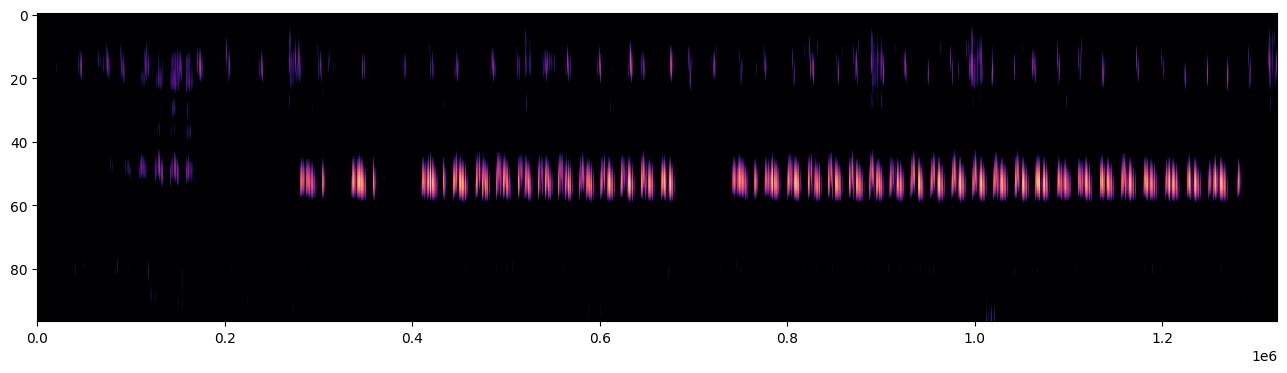

In [ ]:
cs1, f1 = cwt2(sho, nv=12, sr=SR, low_freq=40)
plt.figure(figsize = (16,4))
plt.imshow(20*np.log10(np.abs(cs1)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-30)
plt.show()

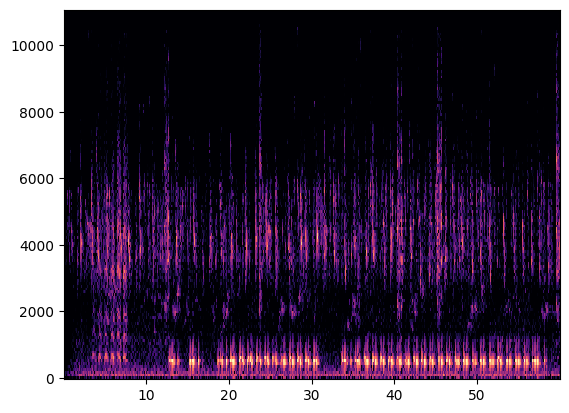

In [ ]:
import scipy.fftpack
from scipy import signal
from scipy.signal import chirp

DB_RANGE = 100
sho = d1_5

# Spectrogram
f, t, Sxx = signal.spectrogram(sho, SR) # spectrogram
plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto', cmap=CMAP, vmax=-60, vmin=-60-DB_RANGE)

In [ ]:
type(d1)
d1.shape

(273000,)

In [ ]:
# load another file with Black-throated Green Warbler
d2 = rd_file('/content/drive/MyDrive/Birdsong/Birds/Phoenicurusochruros184490.mp3')
#d2 = rd_file(TRAIN_DIR+'/btnwar/XC135117.mp3')
#d2 = d2[:500000] # cuting
Audio(d2, rate=SR)

In [ ]:
type(d2)
d2.shape

(501703,)

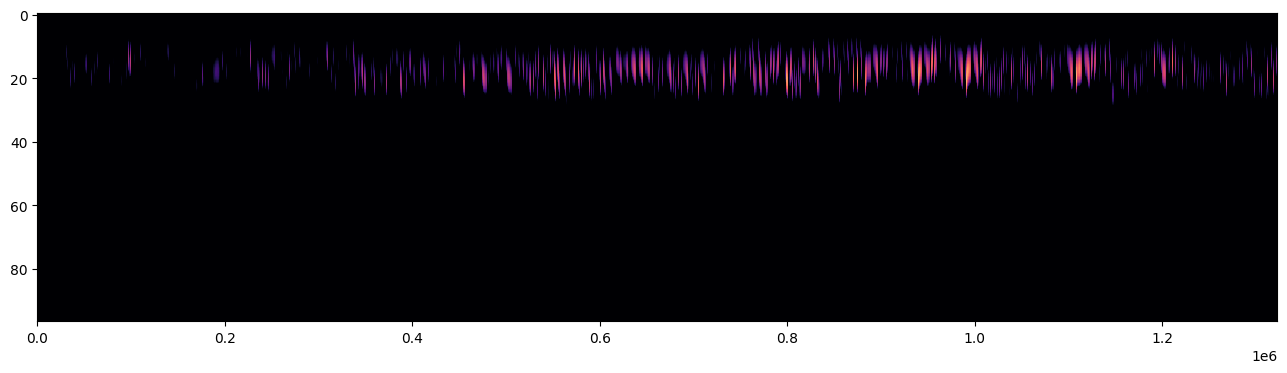

In [ ]:
cs1, f1 = cwt2(d1, nv=12, sr=SR, low_freq=40)
plt.figure(figsize = (16,4))
plt.imshow(20*np.log10(np.abs(cs1)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-30)
plt.show()

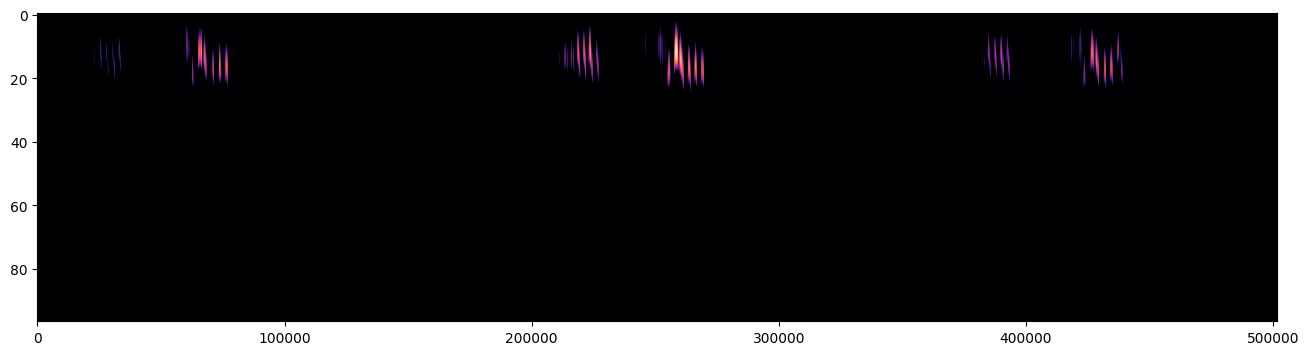

In [ ]:
cs2, f2 = cwt2(d2, nv=12, sr=SR, low_freq=40)
plt.figure(figsize = (16,4))
plt.imshow(20*np.log10(np.abs(cs2)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-30)
plt.show()

In [ ]:
# 단일 call 확대 Pass

In [ ]:
def plot_sigx2(d1, d2, name1='data 1', name2='data 2', cwt=True, db_range=30):
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    d = [d1, d2]
    name = [name1, name2]
    for i in range(2):
        if cwt == True:
            cs, _ = cwt2(d[i], nv=12, sr=SR, low_freq=40)
            axes[i].imshow(20*np.log10(np.abs(cs)),  cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-db_range)
        else:
            f, t, Sxx = signal.spectrogram(d[i], SR)
            axes[i].pcolormesh(t, f, 20*np.log10(Sxx), shading='auto', cmap=CMAP, vmax=-60, vmin=-60-db_range)
        axes[i].set_title(name[i])
    plt.show()

In [ ]:
# plot_sigx2(d1[25000:65000], d2[45000:85000],
#            name1='Black-throated Blue Warbler', name2='Black-throated Green Warbler')

In [ ]:
# plot_sigx2(d1[25000:65000], d2[45000:85000],
#            name1='Black-throated Blue Warbler', name2='Black-throated Green Warbler', cwt=False, db_range=60)

In [ ]:
# plot_sigx2(d1[25000:65000], d2[45000:85000],
#            name1='Black-throated Blue Warbler', name2='Black-throated Green Warbler', db_range=120)

In [ ]:
# plot_sigx2(d1[25000:65000], d2[45000:85000],
#            name1='Black-throated Blue Warbler', name2='Black-throated Green Warbler', cwt=False, db_range=120)

In [ ]:
# 같은 노래를 두 번 부르지 않는 새인 북부 흉내지빠귀의 녹음을 시도 pass

In [ ]:
# d3 = rd_file(TRAIN_DIR+'/normoc/XC54018.mp3', offset=127, duration=10)
# Audio(d3, rate=SR)

In [ ]:
# # Scaleogram
# cs3a, f3 = cwt2(d3, nv=12, sr=SR, low_freq=40)
# cs3b=np.zeros((97,10*SR), dtype=np.complex)
# for i in range(10):
#     cs3b[:,i*SR:(i+1)*SR], _ = cwt2(d3[i*SR:(i+1)*SR], nv=12, sr=SR, low_freq=40)
# fig, axes = plt.subplots(3, 1, figsize=(16,12))
# axes[0].imshow(20*np.log10(np.abs(cs3a)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-40)
# axes[0].set_title('Scaleogram - 10s')
# axes[1].imshow(20*np.log10(np.abs(cs3b)), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-40)
# axes[1].set_title('Scaleogram - 10 x 1s')
# diff = np.abs(np.abs(cs3a)-np.abs(cs3b))
# diff[diff == 0.] = 1e-15
# axes[2].imshow(20*np.log10(diff), cmap=CMAP, aspect='auto', norm=None, vmax=0, vmin=-40)
# axes[2].set_title('Scaleogram - difference')
# plt.show()

In [ ]:
# # Spectrogram
# f, t, Sxxa = signal.spectrogram(d3, SR)
# Sxxb=np.zeros((129,10*98))
# for i in range(10):
#     _, _, Sxxb[:,i*98:(i+1)*98] = signal.spectrogram(d3[i*SR:(i+1)*SR])
# fig, axes = plt.subplots(3, 1, figsize=(16,12))
# axes[0].pcolormesh(t[0:980], f, 20*np.log10(Sxxa[:,0:980]), shading='auto', cmap=CMAP, vmax=-90, vmin=-130)
# axes[0].set_title('Spectrogram - 10s')
# axes[1].pcolormesh(t[0:980], f, 20*np.log10(Sxxb), shading='auto', cmap=CMAP, vmax=-0, vmin=-40)
# axes[1].set_title('Spectrogram - 10 x 1s')
# diff = np.abs(np.abs(Sxxa[:,0:980]*3e4)-np.abs(Sxxb))
# diff[diff == 0.] = 1e-15
# axes[2].pcolormesh(t[0:980], f, 20*np.log10(diff), shading='auto', cmap=CMAP, vmax=-0, vmin=-40)
# axes[2].set_title('Spectrogram - difference')
# plt.show()

In [ ]:
# A summary so far:  Spectrogram (based on FFT): Easy to understand, hard to use Scaleogram (based on CWT): Hard to understand, easy to use.
# 스펙토그램은 이해는 쉽지만 사용하기 어렵다. 스케일그램은 이해는 어려워도 사용은 쉽다.

In [ ]:
# Automatic signature extraction 신호 자동 추출
# So, what we need now is an automated way of extracting these bird signatures, and dump the signatures to jpeg files as input to an image classification model.
# There are many ways to locate signatures in recordings, and a basic, rule-based one is used below.
# Of course, these are easy birds, and more difficult birds (or noisy recordings) present a whole range of challenges...

In [ ]:
# calculate variance of coefficients
def calc_var(cs, thres):
    c = 20*np.log10(np.abs(cs))
    c[c < thres] = 0.
    e = np.var(c, axis=0)
    return e / max(e)

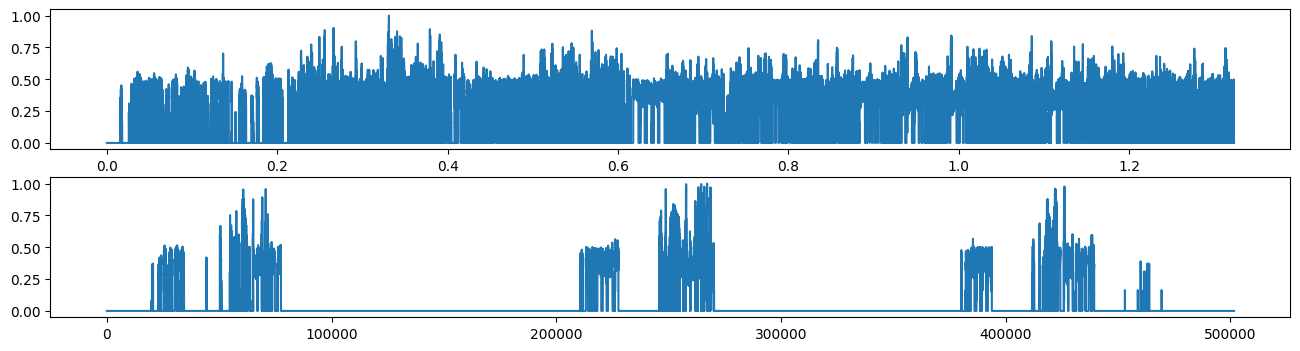

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16,4))
v1 = calc_var(cs1, -30)
axes[0].plot(v1)
v2 = calc_var(cs2, -30)
axes[1].plot(v2)
plt.show()

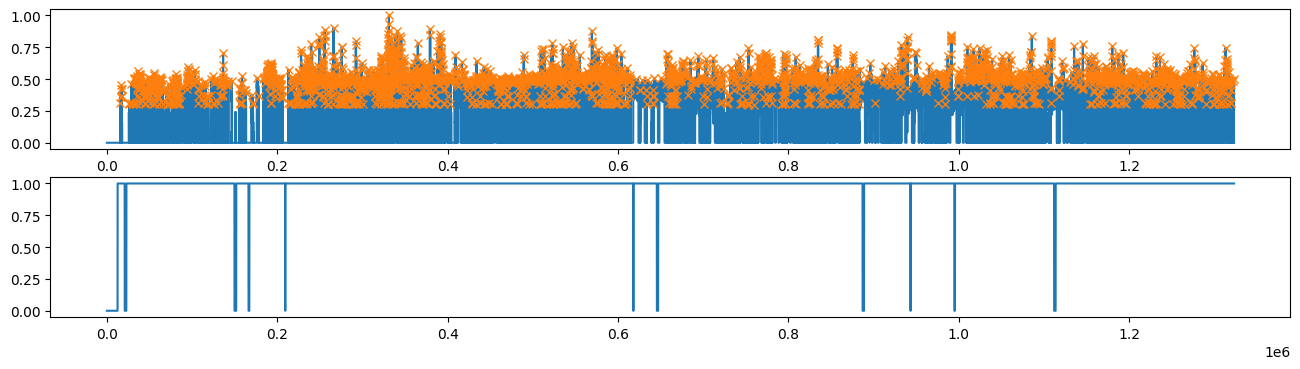

In [ ]:
from scipy.signal import find_peaks

def mask_sig(n, peaks, sr=22050, dur=0.1):
    mask = np.zeros(n)
    subm = int(sr*dur*0.5)
    if len(peaks > 0):
        for i in range(len(peaks)):
            mask[max(peaks[i]-subm, 0): min(peaks[i]+subm, n)] = 1
    return mask

fig, axes = plt.subplots(2, 1, figsize=(16,4))
# peak detection + gliding window
peaks, _ = find_peaks(v1, prominence=0.3)
axes[0].plot(v1)
axes[0].plot(peaks, v1[peaks], "x")
m = mask_sig(len(v1), peaks, SR, 0.3)
axes[1].plot(m)
plt.show()

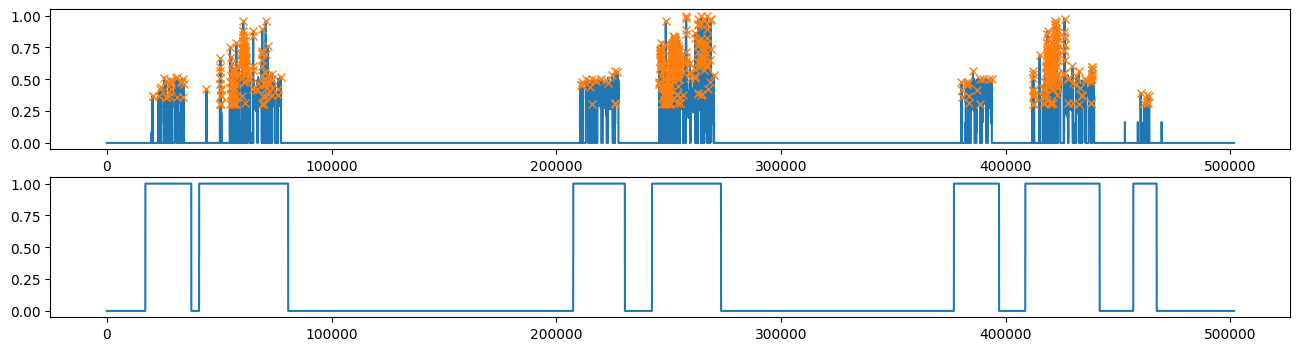

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16,4))
# peak detection + gliding window
peaks, _ = find_peaks(v2, prominence=0.3)
axes[0].plot(v2)
axes[0].plot(peaks, v2[peaks], "x")
m = mask_sig(len(v2), peaks, SR, 0.3)
axes[1].plot(m)
plt.show()

In [ ]:
# Pick

In [ ]:
def get_mask(vdata, prom=0.2, dur=0.2, sr=22050):
    peaks, _ = find_peaks(vdata, prominence=prom)
    return mask_sig(len(vdata), peaks, sr, dur)

def get_regions(mask, sr, species, filename):
    regions = scipy.ndimage.find_objects(scipy.ndimage.label(mask)[0])
    regs = []
    for r in regions:
        dur = round((r[0].stop-r[0].start)/sr,3)
        regs.append([r[0].start, r[0].stop, dur,species,filename])
    return pd.DataFrame(regs, columns=['Start', 'End', 'Duration','Species','File'])

In [ ]:
mask = get_mask(v1, prom=0.3, dur=0.2, sr=SR)
df = get_regions(mask, SR, 'btbwar', 'XC139608.mp3')
df.head(6)

In [ ]:
df = df[df.Duration >= 1.0]
df = df.reset_index(drop=True)
df

In [ ]:
# we plot two seconds
plot_sigx2(d1[df.Start[0]:df.Start[0]+2*SR], d2[df.Start[1]:df.Start[1]+2*SR],
           name1='btbwar 1', name2='btbwar 2')

In [ ]:
mask = get_mask(v2, prom=0.3, dur=0.2, sr=SR)
df = get_regions(mask, SR, 'btnwar', 'XC135117.mp3')
df = df[df.Duration >= 1.0]
df = df.reset_index(drop=True)
df

In [ ]:
plot_sigx2(d2[df.Start[0]:df.Start[0]+2*SR], d2[df.Start[1]:df.Start[1]+2*SR],
           name1='btnwar 1', name2='btnwar 2')

In [ ]:
# free up memory
%xdel d1
%xdel d2
%xdel cs1
%xdel cs2

In [ ]:
# %whos

In [ ]:
# create images

In [ ]:
def img_resize(cs, w=512, h=512, log=True, lthres=-30):
    buf = io.BytesIO()
    if log == True:
        plt.imsave(buf, 20*np.log10(np.abs(cs)), cmap=CMAP, format='png', vmax=0, vmin=lthres)
    else:
        plt.imsave(buf, np.abs(cs), cmap=CMAP, format='png')
    buf.seek(0)
    img_bytes = np.asarray(bytearray(buf.read()), dtype=np.uint8)
    img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    return cv2.resize(img, (w, h), interpolation=cv2.INTER_NEAREST)

# Parameters:
#   filename: mp3-file
#   voices: # of scales per octave
#   sr: sampling frequency (Hz)
#   low_freq: low freq cutoff (Hz)
#   thres: scaleogram threshold (dB)
#   prom: peak detect prominence
#   peakdur: peak extension (s)
#   sigthres: smallest signature detection to process (s)
#   siglen: length of output signature (s)
#   img_size: output image size
#   outdir: output directory
def scaleo_extract(filename, voices=12, sr=22050, low_freq=40, thres=-30, prom=0.3,
                   peakdur=0.3, sigthres=1, siglen=2, img_size=512, outdir='.'):
    d = rd_file(filename)
    cs, _ = cwt2(d, nv=voices, sr=sr, low_freq=low_freq) # wavelet transform
    v = calc_var(cs, thres) # coefficient variance
    peaks, _ = find_peaks(v, prominence=prom)
    m = mask_sig(len(v), peaks, sr=sr, dur=peakdur) # create signal mask
    df = get_regions(m, sr, filename.split('/')[-3], filename.split('/')[-1])
    df = df[df.Duration >= sigthres] # filter out insignificant signatures
    df = df.reset_index(drop=True)
    if len(df) > 0:
        for i in range(len(df)):
            img = img_resize(cs[:,df.Start[i]:df.Start[i]+siglen*sr],
                             w=img_size, h=img_size, log=True, lthres=thres)
            fn = filename.split('/')[-1].split('.')[-2]+"-{:03d}.jpg".format(i)
            cv2.imwrite(outdir+'/'+fn, img)
    return df

In [ ]:
pwd

In [ ]:
%mkdir ./savefile

In [ ]:
# TRAIN_DIR = '/scratch/e1372a04/workspace/test2_birdsong'
# d1 = rd_file('/scratch/e1372a04/workspace/test2_birdsong/HereData/Alaudaarvensis/Germany/Alaudaarvensis105516.mp3')
# d2 = rd_file('/scratch/e1372a04/workspace/test2_birdsong/HereData/Phoenicurusochruros/Germany/Phoenicurusochruros184490.mp3')

In [ ]:
flist = ['/HereData/Alaudaarvensis/Germany/Alaudaarvensis105516.mp3']
for i in flist:
    scaleo_extract(TRAIN_DIR+i, outdir='./savefile')

In [ ]:
import glob
images = glob.glob('./savefile' + "/Alaudaarvensis*.jpg")
plt.figure(figsize=(20,20))
# columns = 4
for i, image in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(mpimg.imread(image))
    plt.axis('off')

In [ ]:
flist = ['/HereData/Phoenicurusochruros/Germany/Phoenicurusochruros184490.mp3']
for i in flist:
    scaleo_extract(TRAIN_DIR+i, outdir='./savefile')

In [ ]:
images = glob.glob('./savefile' + "/Phoenicurusochruros*.jpg")
plt.figure(figsize=(20,25))
# columns = 5
for i, image in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(mpimg.imread(image))
    plt.axis('off')